# Scenario Olten

Overview of needed variables:

- olten_grid: Type = List[List[Int]]
- level_free_positions: Type = Set[Tuple[Int, Int]]
- olten_coordinate_map: Dict[Tuple[Int, Int]: Tuple[Float, Float]]
- olten_line: Type = Line
- olten_timetable: Type = Timetable

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath("../../flatland-rl/"))  # noqa:E402

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import numpy as np

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Helper functions

In [5]:
from flatland.core.grid.rail_env_grid import RailEnvTransitions, RailEnvTransitionsEnum

elements = {
    'north': {
        'empty': {'element': RailEnvTransitionsEnum.empty, 'orientation': 'north'},
        'n': {'element': RailEnvTransitionsEnum.vertical_straight, 'orientation': 'north'},
        'w': {'element': RailEnvTransitionsEnum.right_turn_from_west, 'orientation': 'west'},
        'e': {'element': RailEnvTransitionsEnum.right_turn_from_south, 'orientation': 'east'},
        'ssnw': {'element': RailEnvTransitionsEnum.simple_switch_south_right, 'orientation': 'north'},
        'ssws': {'element': RailEnvTransitionsEnum.simple_switch_east_right, 'orientation': 'west'},
        'ssse': {'element': RailEnvTransitionsEnum.simple_switch_north_right, 'orientation': 'north'},
        'ssse_e': {'element': RailEnvTransitionsEnum.simple_switch_north_right, 'orientation': 'east'},
        'sses': {'element': RailEnvTransitionsEnum.simple_switch_west_left, 'orientation': 'east'},
        'ssne': {'element': RailEnvTransitionsEnum.simple_switch_south_left, 'orientation': 'north'},
        'sssw': {'element': RailEnvTransitionsEnum.simple_switch_north_left, 'orientation': 'north'},
        'sssw_w': {'element': RailEnvTransitionsEnum.simple_switch_north_left, 'orientation': 'west'},
        'c': {'element': RailEnvTransitionsEnum.diamond_crossing, 'orientation': 'north'},
        'sslnw': {'element': RailEnvTransitionsEnum.single_slip_NW, 'orientation': 'north'},
        'sslsw': {'element': RailEnvTransitionsEnum.single_slip_SW, 'orientation': 'north'},
        'sslsw_w': {'element': RailEnvTransitionsEnum.single_slip_SW, 'orientation': 'west'},
        'ssles': {'element': RailEnvTransitionsEnum.single_slip_SE, 'orientation': 'north'},
        'ssles_e': {'element': RailEnvTransitionsEnum.single_slip_SE, 'orientation': 'east'},
        'sslne': {'element': RailEnvTransitionsEnum.single_slip_NE, 'orientation': 'north'},
        'dslne': {'element': RailEnvTransitionsEnum.double_slip_NE_SW, 'orientation': 'north'},
        'dslne_w': {'element': RailEnvTransitionsEnum.double_slip_NE_SW, 'orientation': 'west'},
        'dslnw': {'element': RailEnvTransitionsEnum.double_slip_NW_SE, 'orientation': 'north'},
        'dslnw_e': {'element': RailEnvTransitionsEnum.double_slip_NW_SE, 'orientation': 'east'},
        'sysw': {'element': RailEnvTransitionsEnum.symmetric_switch_from_west, 'orientation': 'west'},
        'syss_e': {'element': RailEnvTransitionsEnum.symmetric_switch_from_south, 'orientation': 'east'},
        'syss_w': {'element': RailEnvTransitionsEnum.symmetric_switch_from_south, 'orientation': 'west'},
        'syse': {'element': RailEnvTransitionsEnum.symmetric_switch_from_east, 'orientation': 'east'},
        'de': {'element': RailEnvTransitionsEnum.dead_end_from_south, 'orientation': 'north'},
    },
    'east': {
        'empty': {'element': RailEnvTransitionsEnum.empty, 'orientation': 'east'},
        'e': {'element': RailEnvTransitionsEnum.horizontal_straight, 'orientation': 'east'},
        'n': {'element': RailEnvTransitionsEnum.right_turn_from_north, 'orientation': 'north'},
        's': {'element': RailEnvTransitionsEnum.right_turn_from_west, 'orientation': 'south'},
        'ssnw': {'element': RailEnvTransitionsEnum.simple_switch_south_right, 'orientation': 'north'},
        'ssws': {'element': RailEnvTransitionsEnum.simple_switch_east_right, 'orientation': 'east'},
        'ssws_s': {'element': RailEnvTransitionsEnum.simple_switch_east_right, 'orientation': 'south'},
        'ssen': {'element': RailEnvTransitionsEnum.simple_switch_west_right, 'orientation': 'east'},
        'sswn': {'element': RailEnvTransitionsEnum.simple_switch_east_left, 'orientation': 'east'},
        'sswn_n': {'element': RailEnvTransitionsEnum.simple_switch_east_left, 'orientation': 'north'},
        'sssw': {'element': RailEnvTransitionsEnum.simple_switch_north_left, 'orientation': 'south'},
        'sses': {'element': RailEnvTransitionsEnum.simple_switch_west_left, 'orientation': 'east'},
        'c': {'element': RailEnvTransitionsEnum.diamond_crossing, 'orientation': 'east'},
        'sslnw': {'element': RailEnvTransitionsEnum.single_slip_NW, 'orientation': 'east'},
        'sslnw_n': {'element': RailEnvTransitionsEnum.single_slip_NW, 'orientation': 'north'},
        'sslsw': {'element': RailEnvTransitionsEnum.single_slip_SW, 'orientation': 'east'},
        'sslsw_s': {'element': RailEnvTransitionsEnum.single_slip_SW, 'orientation': 'south'},
        'ssles': {'element': RailEnvTransitionsEnum.single_slip_SE, 'orientation': 'east'},
        'sslne': {'element': RailEnvTransitionsEnum.single_slip_NE, 'orientation': 'east'},
        'dslne': {'element': RailEnvTransitionsEnum.double_slip_NE_SW, 'orientation': 'east'},
        'dslne_s': {'element': RailEnvTransitionsEnum.double_slip_NE_SW, 'orientation': 'south'},
        'dslnw': {'element': RailEnvTransitionsEnum.double_slip_NW_SE, 'orientation': 'east'},
        'dslnw_n': {'element': RailEnvTransitionsEnum.double_slip_NW_SE, 'orientation': 'north'},
        'sysn': {'element': RailEnvTransitionsEnum.symmetric_switch_from_north, 'orientation': 'north'},
        'sysw_n': {'element': RailEnvTransitionsEnum.symmetric_switch_from_west, 'orientation': 'north'},
        'sysw_s': {'element': RailEnvTransitionsEnum.symmetric_switch_from_west, 'orientation': 'south'},
        'syss': {'element': RailEnvTransitionsEnum.symmetric_switch_from_south, 'orientation': 'south'},
        'de': {'element': RailEnvTransitionsEnum.dead_end_from_west, 'orientation': 'east'},
    },
    'south': {
        'empty': {'element': RailEnvTransitionsEnum.empty, 'orientation': 'south'},
        's': {'element': RailEnvTransitionsEnum.vertical_straight, 'orientation': 'south'},
        'w': {'element': RailEnvTransitionsEnum.right_turn_from_north, 'orientation': 'west'},
        'e': {'element': RailEnvTransitionsEnum.right_turn_from_east, 'orientation': 'east'},
        'ssnw': {'element': RailEnvTransitionsEnum.simple_switch_south_right, 'orientation': 'south'},
        'ssnw_w': {'element': RailEnvTransitionsEnum.simple_switch_south_right, 'orientation': 'west'},
        'ssse': {'element': RailEnvTransitionsEnum.simple_switch_north_right, 'orientation': 'south'},
        'ssen': {'element': RailEnvTransitionsEnum.simple_switch_west_right, 'orientation': 'east'},
        'ssne': {'element': RailEnvTransitionsEnum.simple_switch_south_left, 'orientation': 'south'},
        'ssne_e': {'element': RailEnvTransitionsEnum.simple_switch_south_left, 'orientation': 'east'},
        'sswn': {'element': RailEnvTransitionsEnum.simple_switch_east_left, 'orientation': 'west'},
        'sssw': {'element': RailEnvTransitionsEnum.simple_switch_north_left, 'orientation': 'south'},
        'c': {'element': RailEnvTransitionsEnum.diamond_crossing, 'orientation': 'south'},
        'sslnw': {'element': RailEnvTransitionsEnum.single_slip_NW, 'orientation': 'south'},
        'sslnw_w': {'element': RailEnvTransitionsEnum.single_slip_NW, 'orientation': 'west'},
        'sslsw': {'element': RailEnvTransitionsEnum.single_slip_SW, 'orientation': 'south'},
        'ssles': {'element': RailEnvTransitionsEnum.single_slip_SE, 'orientation': 'south'},
        'sslne': {'element': RailEnvTransitionsEnum.single_slip_NE, 'orientation': 'south'},
        'sslne_e': {'element': RailEnvTransitionsEnum.single_slip_NE, 'orientation': 'east'},
        'dslne': {'element': RailEnvTransitionsEnum.double_slip_NE_SW, 'orientation': 'south'},
        'dslne_e': {'element': RailEnvTransitionsEnum.double_slip_NE_SW, 'orientation': 'east'},
        'dslnw': {'element': RailEnvTransitionsEnum.double_slip_NW_SE, 'orientation': 'south'},
        'dslnw_w': {'element': RailEnvTransitionsEnum.double_slip_NW_SE, 'orientation': 'west'},
        'sysw': {'element': RailEnvTransitionsEnum.symmetric_switch_from_west, 'orientation': 'west'},
        'sysn_e': {'element': RailEnvTransitionsEnum.symmetric_switch_from_north, 'orientation': 'east'},
        'sysn_w': {'element': RailEnvTransitionsEnum.symmetric_switch_from_north, 'orientation': 'west'},
        'syse': {'element': RailEnvTransitionsEnum.symmetric_switch_from_east, 'orientation': 'east'},
        'de': {'element': RailEnvTransitionsEnum.dead_end_from_north, 'orientation': 'south'},
    },
    'west': {
        'empty': {'element': RailEnvTransitionsEnum.empty, 'orientation': 'west'},
        'w': {'element': RailEnvTransitionsEnum.horizontal_straight, 'orientation': 'west'},
        'n': {'element': RailEnvTransitionsEnum.right_turn_from_east, 'orientation': 'north'},
        's': {'element': RailEnvTransitionsEnum.right_turn_from_south, 'orientation': 'south'},
        'ssws': {'element': RailEnvTransitionsEnum.simple_switch_east_right, 'orientation': 'west'},
        'ssse': {'element': RailEnvTransitionsEnum.simple_switch_north_right, 'orientation': 'south'},
        'ssen': {'element': RailEnvTransitionsEnum.simple_switch_west_right, 'orientation': 'west'},
        'ssen_n': {'element': RailEnvTransitionsEnum.simple_switch_west_right, 'orientation': 'north'},
        'ssne': {'element': RailEnvTransitionsEnum.simple_switch_south_left, 'orientation': 'north'},
        'sswn': {'element': RailEnvTransitionsEnum.simple_switch_east_left, 'orientation': 'west'},
        'sses': {'element': RailEnvTransitionsEnum.simple_switch_west_left, 'orientation': 'west'},
        'sses_s': {'element': RailEnvTransitionsEnum.simple_switch_west_left, 'orientation': 'south'},
        'c': {'element': RailEnvTransitionsEnum.diamond_crossing, 'orientation': 'west'},
        'sslnw': {'element': RailEnvTransitionsEnum.single_slip_NW, 'orientation': 'west'},
        'sslsw': {'element': RailEnvTransitionsEnum.single_slip_SW, 'orientation': 'west'},
        'ssles': {'element': RailEnvTransitionsEnum.single_slip_SE, 'orientation': 'west'},
        'ssles_s': {'element': RailEnvTransitionsEnum.single_slip_SE, 'orientation': 'south'},
        'sslne': {'element': RailEnvTransitionsEnum.single_slip_NE, 'orientation': 'west'},
        'sslne_n': {'element': RailEnvTransitionsEnum.single_slip_NE, 'orientation': 'north'},
        'dslne': {'element': RailEnvTransitionsEnum.double_slip_NE_SW, 'orientation': 'west'},
        'dslne_n': {'element': RailEnvTransitionsEnum.double_slip_NE_SW, 'orientation': 'north'},
        'dslnw': {'element': RailEnvTransitionsEnum.double_slip_NW_SE, 'orientation': 'west'},
        'dslnw_n': {'element': RailEnvTransitionsEnum.double_slip_NW_SE, 'orientation': 'south'},
        'sysn': {'element': RailEnvTransitionsEnum.symmetric_switch_from_north, 'orientation': 'north'},
        'syse_n': {'element': RailEnvTransitionsEnum.symmetric_switch_from_east, 'orientation': 'north'},
        'syse_s': {'element': RailEnvTransitionsEnum.symmetric_switch_from_east, 'orientation': 'south'},
        'syss': {'element': RailEnvTransitionsEnum.symmetric_switch_from_south, 'orientation': 'south'},
        'de': {'element': RailEnvTransitionsEnum.dead_end_from_east, 'orientation': 'west'},
    },
}

In [6]:
with open('elements.pkl', 'wb') as f:
    pickle.dump(elements,f)

In [7]:
def go_to_next_cell(x: int, y: int, orientation: str):
    assert orientation in ['north', 'east', 'south', 'west'], "Invalid orientation (allowed: 'north', 'east', 'south', 'west')"
    
    if orientation == 'north':
        return x,y+1
    elif orientation == 'east':
        return x+1,y
    elif orientation == 'south':
        return x,y-1
    elif orientation == 'west':
        return x-1,y

In [8]:
def step_back(x: int, y: int, orientation: str):
    assert orientation in ['north', 'east', 'south', 'west'], "Invalid orientation (allowed: 'north', 'east', 'south', 'west')"
    
    if orientation == 'north':
        return x,y-1
    elif orientation == 'east':
        return x-1,y
    elif orientation == 'south':
        return x,y+1
    elif orientation == 'west':
        return x+1,y

In [9]:
def convert_coordinates(grid: np.array, x: int, y: int, x_origin: int = 0, y_origin: int = 0):
    n, e = grid.shape
    
    i = n - y - 1 - y_origin
    j = x + x_origin
    
    return i, j

In [10]:
def place_element(grid: np.array, x: int, y: int, orientation: str, element: str, x_origin: int = 0, y_origin: int = 0):

    # place element and adjust orientation
    element, orientation = elements[orientation][element].values()
    i, j = convert_coordinates(grid, x, y, x_origin, y_origin)
    grid[i][j] = element.value
    
    # go to next cell
    x,y = go_to_next_cell(x, y, orientation)

    return grid, x, y, orientation

In [11]:
def place_line(grid: np.array, x0: int, y0: int, orientation: str, line: list, x_origin: int = 0, y_origin: int = 0, return_line: bool = False, return_endpoint: bool = False):
    x = x0
    y = y0
    
    list_line = []
    
    for element in line:
        list_line.append(tuple([x,y]))
        grid, x, y, orientation = place_element(grid, x, y, orientation, element, x_origin, y_origin)
    
    if return_endpoint:
        x, y = step_back(x, y, orientation)
        if return_line:
            return grid, list_line, (x, y)
        else:
            return grid, (x, y)
    
    if return_line:
        return grid, list_line
    
    return grid

## Grid

In [12]:
from flatland.core.grid.rail_env_grid import RailEnvTransitionsEnum

In [13]:
# create grid
height = 60
width = 35
grid_shape = tuple([width, height]) 

x_origin = 7
y_origin = 20
coord_origin = tuple([x_origin, y_origin])

grid = np.array([[0]*width]*height)

# create lines

# 1st line
x0, y0 = 0, 0
line1 = ['n']*4 + ['e']
line2 = ['e']
grid, line_1n = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True)
grid, line_1s = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True)
line_1 = list(reversed(line_1s)) + line_1n[1:]

# 2nd line
x0, y0 = 1, 0
line1 = ['n']*4 + ['ssnw','ssne'] + ['n']*7 + ['sssw','n','n','ssse','ssne','ssnw','n','ssse','ssnw'] + ['n']*5 + ['e']*9 + ['sswn_n','n','n'] + ['w']*18
line2 = ['sssw','ssne'] + ['s']*4 + ['e','s','s','s','ssse','w'] + ['w']*9
grid, line_2n, end2north = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
grid, line_2s, end2south = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
line_2 = list(reversed(line_2s)) + line_2n[1:]

# 3rd line
x0, y0 = 2, 0
line1 = ['n']*5 + ['sssw','ssne'] + ['n']*7 + ['ssne','n','ssnw','sssw','e']
line2 = ['s', 'sssw','s','e']
grid, line_3n = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True)
grid, line_3s = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True)
line_3 = list(reversed(line_3s)) + line_3n[1:]

# 4rd line
x0, y0 = 3, 0
line1 = ['n']*6 + ['sssw','ssne'] + ['n']*4 + ['ssne','n','sssw','ssse','n','n','ssnw','e','sses'] + ['e']*6 + ['c']*2 + ['e']*5 + ['ssen'] + ['e']*3 + ['sswn','sses','e','ssws','e','e']
line2 = ['s']*3 + ['sssw','s','s','ssne','s','s','ssnw','ssse','w'] + ['w']*10
grid, line_4e, end4east = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
grid, line_4s, end4south = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
line_4 = list(reversed(line_4s)) + line_4e[1:]

# 5th line
x0, y0 = 4, 0
line1 = ['n']*7 + ['sssw','ssne','n','ssse','ssne','sssw','n','ssse','ssnw','ssne','n','ssse_e'] + ['e']*6 + ['c']*2 + ['e']*10 + ['n']
line2 = ['s']*3 + ['ssse','s','s','ssnw','s','s','s','ssnw','ssne','s','s'] + ['w']*7 + ['s']*7
grid, line_5n = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True)
grid, line_5s, end5south = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
line_5 = list(reversed(line_5s)) + line_5n[1:]

# 6th line
x0, y0 = 5, 0
line1 = ['n']*8 + ['w']
line2 = ['s','ssse','s','ssnw'] + ['s']*3 + ['ssse'] + ['s']*3 + ['sssw','s','ssne','s'] + ['w']*7 + ['s']*6
grid, line_6n = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True)
grid, line_6s, end6south = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
line_6 = list(reversed(line_6s)) + line_6n[1:]

# cross
x0, y0 = 5, 11
line = ['s','c','e']
grid, line_cross = place_line(grid, x0, y0, 'east', line, x_origin = x_origin, y_origin = y_origin, return_line=True)

# 7th line
x0, y0 = 6, 0
line1 = ['n']*5 + ['ssse'] + ['n']*3 + ['sssw','ssnw','n','w','n','n','ssnw','n','sssw'] + ['e']*6 + ['c']*2 + ['e']*11 + ['n','e','ssen','e','e'] 
line2 = ['s','ssnw','s','ssse','s','ssse','s','ssnw'] + ['s']*5 + ['sssw','s','ssne'] + ['s']*5
grid, line_7e, end7east = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
grid, line_7s, end7south = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
line_7 = list(reversed(line_7s)) + line_7e[1:]

# 8th line
x0, y0 = 7, 0
line1 = ['n']*5 + ['ssnw','n','ssne'] + ['n']*4 + ['e']*2 + ['ssws','sses'] + ['n']*5 + ['c']*4 + ['n']*6 + ['ssnw','e']
line2 = ['ssse','s','s','w']
grid, line_8n = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True)
grid, line_8s = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True)
line_8 = list(reversed(line_8s)) + line_8n[1:]

# 9th line
x0, y0 = 8, 0
line1 = ['n']*5 + ['ssne','n','sssw','n', 'e']
line2 = ['ssnw','s','ssse','s','w','s','ssnw'] + ['s']*9 + ['sssw'] + ['s']*5 
grid, line_9n = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True)
grid, line_9s, end9south = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
line_9 = list(reversed(line_9s)) + line_9n[1:]

# 10th line
x0, y0 = 9, 0
line1 = ['n']*5 + ['sssw','n','n','n','ssnw','n','syse','sswn','e'] + ['n']*6 + ['c']*4 + ['n']*6 + ['ssse','ssnw'] + ['e']*4 + ['ssnw'] + ['n']*10
line2 = ['s','s','w']
grid, line_10n, end10north = place_line(grid, x0, y0, 'north', line1, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)
grid, line_10s = place_line(grid, x0, y0, 'south', line2, x_origin = x_origin, y_origin = y_origin, return_line=True)
line_10 = list(reversed(line_10s)) + line_10n[1:]

# 11th line
x0, y0 = 0, 13
line = ['n']*5 + ['ssse','n','n','e']
grid, line_11 = place_line(grid, x0, y0, 'west', line, x_origin = x_origin, y_origin = y_origin, return_line=True)

# 12th line
x0, y0 = 2, 20
line = ['e']*9 + ['c']*2 + ['e']*3 + ['ssen','e','ssws','e','sswn','e','sses','e','e','sswn','e','e'] 
grid, line_12, end12east = place_line(grid, x0, y0, 'east', line, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)

# 13th line
x0, y0 = 16, 21
line = ['n']*6 + ['ssnw','ssse','ssnw']
grid, line_13 = place_line(grid, x0, y0, 'north', line, x_origin = x_origin, y_origin = y_origin, return_line=True)

# 14th line
x0, y0 = 27, 21
end14east = tuple([x0,y0])
line = ['w','w','sses'] + ['w']*4 + ['sses','w','w'] + ['n']*7 + ['ssnw'] + ['n']*11
grid, line_14, end14north = place_line(grid, x0, y0, 'west', line, x_origin = x_origin, y_origin = y_origin, return_line=True, return_endpoint=True)

# 15th line
x0, y0 = 13, 27
line = ['e']*3
grid = place_line(grid, x0, y0, 'east', line, x_origin = x_origin, y_origin = y_origin)


olten_grid = grid.tolist()

In [14]:
with np.printoptions(threshold=np.inf,linewidth=np.inf):
    print(grid)

[[    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 32800 32800     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 32800 32800     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 32800 32800     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 32800 32800     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 32800 32

In [15]:
# display entry points
def display_endpoints():
    print('Line  2 south entry:', end2south)
    print('Line  4 south entry:', end4south)
    print('Line  5 south entry:', end5south)
    print('Line  6 south entry:', end6south)
    print('Line  7 south entry:', end7south)
    print('Line  9 south entry:', end9south)

    print('Line  2 north entry:', end2north)
    print('Line 10 north entry:', end10north)
    print('Line 14 north entry:', end14north)

    print('Line  4 east  entry:', end4east)
    print('Line  7 east  entry:', end7east)
    print('Line 12 east  entry:', end12east)
    print('Line 14 east  entry:', end14east)
    
    return

# display_endpoints()

In [16]:
grid_pkl = {'grid': grid}

with open('olten.pkl', 'wb') as f:
    pickle.dump(grid_pkl,f)

## Lat-Lon Mapping

In [17]:
# transform coordinates 
def transform_coordinates(coordinates: str):
    north, east = coordinates.split('N')
    
    latitude = float(north[:2]) + float(north[4:6])/60 + float(north[8:13])/3600
    longitude = float(east[1:2]) + float(east[4:6])/60 + float(east[8:13])/3600
    
    return latitude, longitude

In [18]:
# create dictionary
def add_to_dict(coordinate_dict: dict, coordinates_LL: str, coordinates_grid: tuple):
    
    coordinates_LL = transform_coordinates(coordinates_LL)
    coordinate_dict[coordinates_grid] = coordinates_LL
    
    return coordinate_dict

In [19]:
# create mapping dictionary
coordinate_map_olten = {}

# Train station
olten1 = tuple([0,2])
olten2 = tuple([1,2])
olten3 = tuple([2,2])
olten4 = tuple([3,2])
olten5 = tuple([4,2])
olten6 = tuple([5,2])
olten7 = tuple([6,2])
olten8 = tuple([7,2])
olten9 = tuple([8,2])
olten10 = tuple([9,2])

coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.90″ N 7° 54′ 25.54″ E', coordinates_grid = olten1)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.89″ N 7° 54′ 25.75″ E', coordinates_grid = olten2)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.86″ N 7° 54′ 26.22″ E', coordinates_grid = olten3)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.84″ N 7° 54′ 26.46″ E' , coordinates_grid = olten4)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.70″ N 7° 54′ 27.79″ E', coordinates_grid = olten5)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.69″ N 7° 54′ 28.03″ E', coordinates_grid = olten6)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.63″ N 7° 54′ 28.77″ E', coordinates_grid = olten7)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.62″ N 7° 54′ 28.97″ E', coordinates_grid = olten8)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.58″ N 7° 54′ 29.48″ E', coordinates_grid = olten9)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 05.55″ N 7° 54′ 29.69″ E', coordinates_grid = olten10)


# entry points
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 56.63″ N 7° 53′ 36.31″ E', coordinates_grid = end2south)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 56.46″ N 7° 53′ 36.29″ E', coordinates_grid = end4south)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 08.39″ N 7° 54′ 08.41″ E', coordinates_grid = end5south)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 08.34″ N 7° 54′ 08.60″ E', coordinates_grid = end6south)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 22.88″ N 7° 54′ 32.65″ E', coordinates_grid = end7south)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 22.87″ N 7° 54′ 32.87″ E', coordinates_grid = end9south)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 53.01″ N 7° 53′ 55.91″ E', coordinates_grid = end2north)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 22′ 13.42″ N 7° 54′ 57.88″ E', coordinates_grid = end10north)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 22′ 13.40″ N 7° 54′ 58.04″ E', coordinates_grid = end14north)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 22.73″ N 7° 55′ 49.53″ E', coordinates_grid = end4east)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 22.61″ N 7° 55′ 49.46″ E', coordinates_grid = end7east)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 22.89″ N 7° 55′ 49.67″ E', coordinates_grid = end12east)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 23.04″ N 7° 55′ 49.72″ E', coordinates_grid = end14east)


# intermediate stops
hammer2 = tuple([-5,-10])
hammer4 = tuple([-5,-11])
trimbach2 = tuple([-2,30])

coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 54.67″ N 7° 53′ 51.65″ E', coordinates_grid = hammer2)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 54.45″ N 7° 53′ 51.37″ E', coordinates_grid = hammer4)
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 57.59″ N 7° 54′ 15.35″ E', coordinates_grid = trimbach2)


# crossings
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 37.24″ N 7° 55′ 01.07″ E', coordinates_grid = tuple([11,20]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 37.33″ N 7° 55′ 01.40″ E', coordinates_grid = tuple([12,20]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.95″ N 7° 55′ 00.82″ E', coordinates_grid = tuple([11,19]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 37.07″ N 7° 55′ 01.16″ E', coordinates_grid = tuple([12,19]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.75″ N 7° 55′ 00.64″ E', coordinates_grid = tuple([11,18]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.84″ N 7° 55′ 00.96″ E', coordinates_grid = tuple([12,18]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.33″ N 7° 55′ 00.17″ E', coordinates_grid = tuple([11,17]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.40″ N 7° 55′ 00.51″ E', coordinates_grid = tuple([12,17]))


# line 2/4 south
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 02.97″ N 7° 54′ 26.05″ E', coordinates_grid = tuple([0,0]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 53.12″ N 7° 54′ 25.25″ E', coordinates_grid = tuple([2,-10]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 48.29″ N 7° 54′ 20.74″ E', coordinates_grid = tuple([0,-10]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 47.00″ N 7° 54′ 06.23″ E', coordinates_grid = tuple([-2,-10]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 53.11″ N 7° 54′ 25.75″ E', coordinates_grid = tuple([3,-11]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 48.12″ N 7° 54′ 20.95″ E', coordinates_grid = tuple([0,-11]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 46.80″ N 7° 54′ 06.19″ E', coordinates_grid = tuple([-2,-11]))

# line 3/8 south
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 59.16″ N 7° 54′ 26.59″ E', coordinates_grid = tuple([2,-3]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 59.11″ N 7° 54′ 27.27″ E', coordinates_grid = tuple([7,-3]))

# line 5/6 south
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 47.70″ N 7° 54′ 25.79″ E', coordinates_grid = tuple([4,-14]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 47.72″ N 7° 54′ 26.08″ E', coordinates_grid = tuple([5,-15]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 25.40″ N 7° 54′ 25.19″ E', coordinates_grid = tuple([-3,-14]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 25.34″ N 7° 54′ 25.38″ E', coordinates_grid = tuple([-2,-15]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 42.26″ N 7° 54′ 27.95″ E', coordinates_grid = tuple([2,-14]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 42.26″ N 7° 54′ 28.13″ E', coordinates_grid = tuple([3,-15]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 35.37″ N 7° 54′ 29.16″ E', coordinates_grid = tuple([0,-14]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 35.34″ N 7° 54′ 29.39″ E', coordinates_grid = tuple([1,-15]))

# line 7/9/10 south
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 00.17″ N 7° 54′ 27.63″ E', coordinates_grid = tuple([8,-4]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 52.34″ N 7° 54′ 26.04″ E', coordinates_grid = tuple([6,-7]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 52.30″ N 7° 54′ 26.26″ E', coordinates_grid = tuple([7,-7]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 36.44″ N 7° 54′ 30.43″ E', coordinates_grid = tuple([6,-16]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 36.45″ N 7° 54′ 30.67″ E', coordinates_grid = tuple([7,-16]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 20′ 59.57″ N 7° 54′ 27.69″ E', coordinates_grid = tuple([9,-2]))

# line 2 north
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 22′ 05.71″ N 7° 54′ 37.89″ E', coordinates_grid = tuple([5,30]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 22′ 03.00″ N 7° 54′ 53.69″ E', coordinates_grid = tuple([10,30]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 53.46″ N 7° 55′ 04.73″ E', coordinates_grid = tuple([10,27]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 38.82″ N 7° 55′ 01.43″ E', coordinates_grid = tuple([1,27]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 23.44″ N 7° 54′ 34.12″ E', coordinates_grid = tuple([1,13]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 45.94″ N 7° 55′ 05.57″ E', coordinates_grid = tuple([5,27]))

# lines 3/4/5/6 north
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 23.39″ N 7° 54′ 34.41″ E', coordinates_grid = tuple([2,13]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 23.32″ N 7° 54′ 34.59″ E', coordinates_grid = tuple([3,13]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 23.24″ N 7° 54′ 34.73″ E', coordinates_grid = tuple([4,13]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 23.13″ N 7° 54′ 34.95″ E', coordinates_grid = tuple([5,13]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 27.57″ N 7° 54′ 42.14″ E', coordinates_grid = tuple([5,9]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 23.81″ N 7° 54′ 35.74″ E', coordinates_grid = tuple([5,7]))

# line 8/9/10 north
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 22.99″ N 7° 54′ 37.29″ E', coordinates_grid = tuple([7,12]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 24.26″ N 7° 54′ 40.05″ E', coordinates_grid = tuple([8,9]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 22.88″ N 7° 54′ 37.56″ E', coordinates_grid = tuple([9,11]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 54.30″ N 7° 55′ 04.66″ E', coordinates_grid = tuple([11,27]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 58.11″ N 7° 55′ 03.29″ E', coordinates_grid = tuple([16,29]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 45.89″ N 7° 55′ 05.94″ E', coordinates_grid = tuple([11,24]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 45.89″ N 7° 55′ 06.12″ E', coordinates_grid = tuple([12,24]))

# lines east
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 34.87″ N 7° 54′ 55.33″ E', coordinates_grid = tuple([2,20]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 38.57″ N 7° 55′ 10.01″ E', coordinates_grid = tuple([15,20]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 38.39″ N 7° 55′ 10.01″ E', coordinates_grid = tuple([15,19]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 38.27″ N 7° 55′ 10.00″ E', coordinates_grid = tuple([15,18]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 38.01″ N 7° 55′ 10.00″ E', coordinates_grid = tuple([15,17]))

coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.18″ N 7° 55′ 23.47″ E', coordinates_grid = tuple([18,21]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.02″ N 7° 55′ 23.33″ E', coordinates_grid = tuple([18,20]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 35.88″ N 7° 55′ 23.19″ E', coordinates_grid = tuple([18,19]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 35.77″ N 7° 55′ 23.04″ E', coordinates_grid = tuple([18,17]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 35.56″ N 7° 55′ 22.76″ E' , coordinates_grid = tuple([18,18]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 28.16″ N 7° 55′ 36.67″ E' , coordinates_grid = tuple([23,19]))

# line 11
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 23.45″ N 7° 54′ 34.09″ E' , coordinates_grid = tuple([0,13]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.66″ N 7° 54′ 58.06″ E' , coordinates_grid = tuple([0,18]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 47.09″ N 7° 55′ 05.72″ E' , coordinates_grid = tuple([0,21]))

# line 13
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 36.04″ N 7° 55′ 23.29″ E' , coordinates_grid = tuple([16,21]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 42.24″ N 7° 55′ 12.57″ E' , coordinates_grid = tuple([16,24]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 54.18″ N 7° 55′ 05.01″ E' , coordinates_grid = tuple([16,29]))

# line 14
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 42.27″ N 7° 55′ 12.75″ E', coordinates_grid = tuple([17,23]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 58.13″ N 7° 55′ 03.59″ E', coordinates_grid = tuple([17,29]))

# cross
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 17.79″ N 7° 54′ 31.16″ E', coordinates_grid = tuple([5,11]))
coordinate_map_olten = add_to_dict(coordinate_dict = coordinate_map_olten, coordinates_LL = '47° 21′ 15.85″ N 7° 54′ 30.72″ E', coordinates_grid = tuple([5,9]))


In [20]:
# transform grid coordinates such that (0,0) is in the top right corner

def grid_coordinates(coords: tuple, coord_origin: tuple = coord_origin, grid_shape: tuple = grid_shape):
    x, y = coords
    x0, y0 = coord_origin
    w, h = grid_shape
    
    i = h - y0 - y - 1
    j = x + x0
    
    return (i, j)

In [21]:
# transform and interpolate train lines

import pandas as pd

def transform_line_latlon(line: list, coordinate_map: dict):
    df = pd.DataFrame()

    df['line'] = line
    df['latlon'] = df['line'].map(coordinate_map)

    df['lat'] = df['latlon'].apply(lambda x: x[0] if type(x) == tuple else np.nan).interpolate()
    df['lon'] = df['latlon'].apply(lambda x: x[1] if type(x) == tuple else np.nan).interpolate()

    return list(zip(df['lat'],df['lon']))

In [22]:
# set crossings as overpasses
list_crossings = [tuple([11,20]), tuple([12,20]), tuple([11,19]), tuple([12,19]), tuple([11,18]), tuple([12,18]), tuple([11,17]), tuple([12,17])]

level_free_positions = set([grid_coordinates(i) for i in list_crossings])

In [23]:
# interpolate train lines

lines = [line_1, line_2, line_3, line_4, line_5, line_6, line_7, line_8, line_9, line_10, line_11, line_12, line_13, line_14, line_cross]

for line in lines:
    transformed_line = transform_line_latlon(line, coordinate_map_olten)

    for coords, coordsLL in zip(line, transformed_line):
        coordinate_map_olten[coords] = coordsLL

In [24]:
# transform to grid coordinates
olten_coordinate_map = {grid_coordinates(i):j for (i,j) in coordinate_map_olten.items()}

## Lines

In [25]:
# train lines
## EAST = 1, NORTH = 0, SOUTH = 2, WEST = 3

agent_1 = [
    [end2south, hammer2, olten1, trimbach2],
    [1, 1, 0, 3],
    end2north,
    0.6,
    [[None,10],[20,40],[160,200],[250,270],[290,None]],
]

agent_2 = [
    [end5south, olten4],
    [0, 0],
    end10north,
    1,
    [[None,50],[50, 90],[165,None]],
]

agent_3 = [
    [end14north, olten9],
    [2, 2],
    end6south,
    1,
    [[None,100],[175,215],[265,None]],
]

agent_4 = [
    [end7east, olten7],
    [3, 2],
    end6south,
    0.8,
    [[None,100],[230,270],[320,None]],
]

agent_5 = [
    [end7east, olten7],
    [3, 2],
    end9south,
    0.6,
    [[None,50],[150,190],[240,None]],
]

agent_6 = [
    [end5south],
    [0],
    end10north,
    1,
    [[None,80],[165,None]],
]

In [26]:
# build Line element and timetable
from flatland.envs.timetable_utils import Line, Timetable

agent_positions = []
agent_directions = []
agent_targets = []
agent_speeds = []

earliest_departures = []
latest_arrivals = []

for agent in [agent_1, agent_2, agent_3, agent_4, agent_5, agent_6]:
    agent_positions.append([grid_coordinates(i) for i in agent[0]])
    agent_directions.append(agent[1])
    agent_targets.append(grid_coordinates(agent[2]))
    agent_speeds.append(agent[3])
    
    earliest_departures.append([item[1] for item in agent[4]])
    latest_arrivals.append([item[0] for item in agent[4]])


olten_line = Line(agent_positions = agent_positions, agent_directions = agent_directions, agent_targets = agent_targets, agent_speeds = agent_speeds)

olten_timetable = Timetable(earliest_departures = earliest_departures, latest_arrivals = latest_arrivals, max_episode_steps = 500)

In [27]:
# define lines (WiP)

line_2s2n = [end2south, end2north, 1, 0.6]
line_2n2s = [end2north, end2south, 3, 0.6]
line_2so = [end2south, olten1, 3, 0.6]
line_o2s = [olten1, end2south, 2, 0.6]
line_2no = [end2north, olten1, 3, 0.6]
line_o2n = [olten1, end2north, 0, 0.6]

line_7s10n = [end7south, end10north, 0, 1] # olten8
line_7so = [end7south, olten9, 0, 0.8]
line_o7s = [olten9, end7south, 2, 0.8]

line_5s10n = [end5south, end10north, 0, 1] # olten4
line_14n6s = [end14north, end6south, 2, 1] # olten9
line_14no = [end14north, olten9, 2, 0.6]
line_o14n = [olten9, end14north, 0, 0.6]
line_14n9s = [end14north, end9south, 2, 1] # olten10


line_5s4e = [end5south, end4east, 0, 1]


line_5so = [end5south, olten7, 0, 0.8]
line_o5s = [olten7, end5south, 2, 0.8]

## Timetable

In [28]:
# import pandas as pd

# df_raw = pd.read_csv('../../../AI4REALNET/Szenario Olten/ist-daten-sbb.csv', sep=';')

In [29]:
# df_raw.columns

In [30]:
# df_olten_all = df_raw[df_raw['Haltestellen Name'] == 'Olten'].copy()
# print('Anzahl Zugdurchfahrten:', df_olten_all[df_olten_all['Durchfahrt TF'] == True].shape[0])

# columns = ['Linien Text', 'Ankunftszeit', 'Abfahrtszeit']
# df_olten = df_olten_all[columns].reset_index(drop=True)

# df_olten['Abfahrtszeit'] = pd.to_datetime(df_olten['Abfahrtszeit'])
# df_olten['Ankunftszeit'] = pd.to_datetime(df_olten['Ankunftszeit'])
# df_olten = df_olten.sort_values(by='Abfahrtszeit')

# start = '2025-03-02 06:00:00'
# end = '2025-03-02 07:00:00'

# condition = (((df_olten['Abfahrtszeit'] >= pd.to_datetime(start)) & (df_olten['Abfahrtszeit'] <= pd.to_datetime(end))) | 
#             (df_olten['Ankunftszeit'] >= pd.to_datetime(start)) & (df_olten['Ankunftszeit'] <= pd.to_datetime(end)))
# df = df_olten[condition]

In [31]:
# df

## Map

In [32]:
import folium

m = folium.Map(location=(47.35333, 7.907785), zoom_start=14)

lines = [line_1, line_2, line_3, line_4, line_5, line_6, line_7, line_8, line_9, line_10, line_11, line_12, line_13, line_14, line_cross]
colors = ['cadetblue', 'darkred', 'beige', 'gray', 'black', 'lightgreen', 'purple', 'orange', 'blue', 'white', 'red', 'lightblue', 'darkpurple', 'lightred', 'darkblue', 'green', 'pink', 'darkgreen', 'lightgray']

for line, color in zip(lines, colors):
    transformed_line = transform_line_latlon(line, coordinate_map_olten)
    
    for coord in transformed_line:
         # if np.isnan(coord).any(): continue
            
        folium.Marker(
            location = [coord[0], coord[1]],
            tooltip = coord,
            icon = folium.Icon(icon="train", prefix="fa", color=color)
        ).add_to(m)

m

## Flatland Env

In [33]:
!printenv

SHELL=/bin/bash
SESSION_MANAGER=local/clever:@/tmp/.ICE-unix/3574,unix/clever:/tmp/.ICE-unix/3574
QT_ACCESSIBILITY=1
COLORTERM=truecolor
XDG_CONFIG_DIRS=/etc/xdg/xdg-ubuntu:/etc/xdg
XDG_MENU_PREFIX=gnome-
GNOME_DESKTOP_SESSION_ID=this-is-deprecated
LC_ADDRESS=de_CH.UTF-8
GNOME_SHELL_SESSION_MODE=ubuntu
LC_NAME=de_CH.UTF-8
SSH_AUTH_SOCK=/run/user/1000/keyring/ssh
XMODIFIERS=@im=ibus
DESKTOP_SESSION=ubuntu
LC_MONETARY=de_CH.UTF-8
SSH_AGENT_PID=3499
KERNEL_LAUNCH_TIMEOUT=40
GTK_MODULES=gail:atk-bridge
PWD=/home/clever/Documents/Flatland/Repos/flatland-scenarios/scenario_olten
XDG_SESSION_DESKTOP=ubuntu
LOGNAME=clever
XDG_SESSION_TYPE=x11
GPG_AGENT_INFO=/run/user/1000/gnupg/S.gpg-agent:0:1
_=/usr/bin/printenv
XAUTHORITY=/run/user/1000/gdm/Xauthority
GJS_DEBUG_TOPICS=JS ERROR;JS LOG
WINDOWPATH=2
HOME=/home/clever
USERNAME=clever
IM_CONFIG_PHASE=1
LANG=en_US.UTF-8
LC_PAPER=de_CH.UTF-8
LS_COLORS=rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:

In [34]:
from flatland.core.transition_map import GridTransitionMap
from flatland.core.grid.rail_env_grid import RailEnvTransitions, RailEnvTransitionsEnum
from flatland.envs.rail_env import RailEnv
from flatland.envs.agent_utils import EnvAgent
from flatland.utils.rendertools import RenderTool
from flatland.envs.rail_env_action import RailEnvActions
from flatland.core.grid.grid4 import Grid4TransitionsEnum

from flatland.env_generation.env_generator import env_generator

from matplotlib import pyplot as plt

In [35]:
def rail_generator_from_grid_map(grid_map):
    def rail_generator(*args,**kwargs):
        return grid_map, {"agents_hints": { "city_positions" : {}}, "level_free_positions": []}
    return rail_generator

def line_generator_from_line(line):
    def line_generator(*args,**kwargs):
        return line
    return line_generator

def timetable_generator_from_timetable(timetable):
    def timetable_generator(*args,**kwargs):
        return timetable
    return timetable_generator

In [36]:
grid_map = GridTransitionMap(width=width, height=height, transitions=RailEnvTransitions())
grid_map.grid = grid

In [37]:
env = RailEnv(
    width=grid.shape[1], height=grid.shape[0],
    rail_generator=rail_generator_from_grid_map(grid_map),
    line_generator=line_generator_from_line(olten_line),
    timetable_generator=timetable_generator_from_timetable(olten_timetable)
)
env.reset()
env

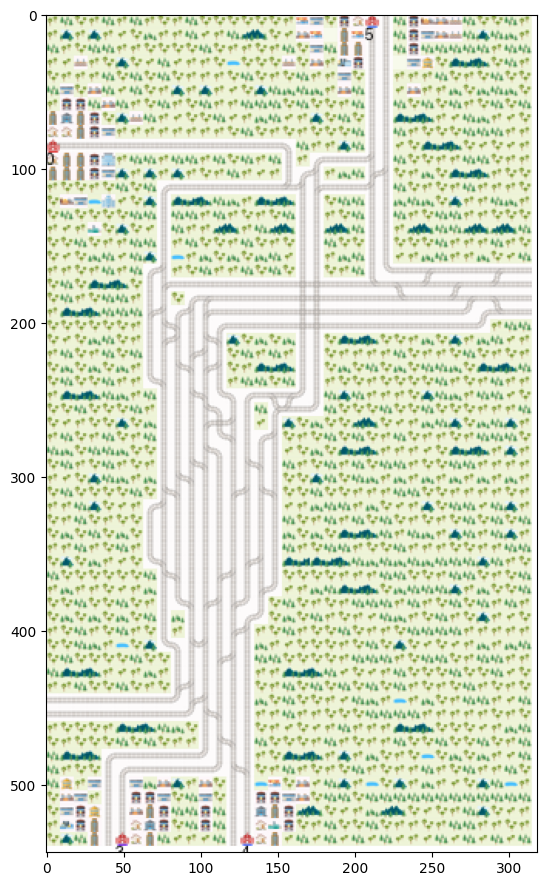

In [38]:
env_renderer = RenderTool(env, gl="PGL", show_debug=True)
env_renderer.render_env(show=False, show_observations=False)
frame = env_renderer.get_image()
dpi = 50
plt.figure(figsize = (frame.shape[1]/dpi, frame.shape[0]/dpi))
plt.imshow(frame)